# Demonstration of `numpyro-oop` usage



In [1]:
import pandas as pd
import numpyro
import numpyro.distributions as dist

from numpyro_oop import BaseNumpyroModel

/Users/tsawallis/.local/share/virtualenvs/numpyro-oop-h_Ko2lEj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Basic regression example

In [2]:
# example from https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html

DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000


In [3]:
def standardize(x):
    return (x - x.mean()) / x.std()


dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

In [4]:
class RegressionModel(BaseNumpyroModel):
    def model(self, data=None):
        if data is None:
            data = self.data

        a = numpyro.sample("a", dist.Normal(0.0, 0.2))
        bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * data.MarriageScaled.values
        sigma = numpyro.sample("sigma", dist.Exponential(1.0))
        mu = a + M
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=data.DivorceScaled.values)

In [5]:
# instantiate the RegressionModel class:
m1 = RegressionModel(data=dset, seed=42)

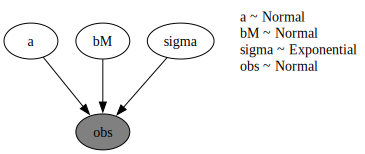

In [6]:
# render the model. (requires graphviz on system level)
m1_graph = numpyro.render_model(
    m1.model,
    render_distributions=True,
    render_params=True,
)
m1_graph

In [7]:
m1.sample()

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro-oop/numpyro_oop/core.py:84: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2022.53it/s, 3 steps of size 8.94e-01. acc. prob=0.90]


In [8]:
m1.mcmc.print_summary(0.90)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.11      0.01     -0.17      0.19   4029.47      1.00
        bM      0.35      0.13      0.35      0.13      0.55   3909.32      1.00
     sigma      0.95      0.10      0.94      0.77      1.09   3576.33      1.00

Number of divergences: 0


In [12]:
preds = m1.predict()

/Users/tsawallis/HESSENBOX-DA/tsawallis/Projects/numpyro-oop/numpyro_oop/core.py:129: UserWarning: Sample's batch dimension size 4000 is different from the provided 200 num_samples argument. Defaulting to 4000.
  predictive = Predictive(


In [16]:
preds["obs"]

Array([[ 1.6542053 ,  1.5443643 ,  0.6107159 , ...,  0.6656364 ,
        -0.76229644,  0.33611342],
       [ 1.6542053 ,  1.5443643 ,  0.6107159 , ...,  0.6656364 ,
        -0.76229644,  0.33611342],
       [ 1.6542053 ,  1.5443643 ,  0.6107159 , ...,  0.6656364 ,
        -0.76229644,  0.33611342],
       ...,
       [ 1.6542053 ,  1.5443643 ,  0.6107159 , ...,  0.6656364 ,
        -0.76229644,  0.33611342],
       [ 1.6542053 ,  1.5443643 ,  0.6107159 , ...,  0.6656364 ,
        -0.76229644,  0.33611342],
       [ 1.6542053 ,  1.5443643 ,  0.6107159 , ...,  0.6656364 ,
        -0.76229644,  0.33611342]], dtype=float32)